Generate FEM solution for 2D Poisson problem

* Test the early termination behavior

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import h5py

import fea.gaussian_random_fields as gr
from fea.fea2d_mesh import SquareMeshThermal
from fea.fea2d_thermal import ThermalFEM
from fea.img_process import project_input
from fea.boundary import define_boundary_nodes

In [2]:
n = 2**8
ntest_data = 1
test_file = "data_thermal/dirich_plate_zero_257x257.h5" 

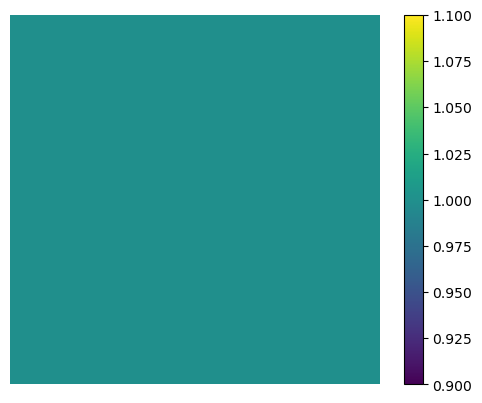

In [3]:
def plot_image(img):
    plt.figure()
    im1 = plt.imshow(img, origin='lower')
    plt.axis('off')
    plt.colorbar(im1)
    
imarray = np.ones((n,n))
plot_image(imarray)

In [4]:
def loading(node_mask, bc):
    '''
    boundary node list: [top, bottom, left, right, curved]

    Randomly assign loadings at boundaries
    ''' 

    h, w = node_mask.shape
    top_idx = np.where(bc[0][0] == 1)
    bottom_idx = np.where(bc[1][0] == 1)
    left_idx = np.where(bc[2][0] == 1)
    right_idx = np.where(bc[3][0] == 1)
    #curved_idx = np.where(bc[4][0] == 1)

    dirich_idx = np.zeros((h, w), dtype=np.int32)
    dirich_value = np.zeros_like(dirich_idx, dtype=np.float32)

    nneumann = 2 # number of neumann boundaries is 2
    neumann_idx = np.zeros((h, w, nneumann), dtype=np.int32)
    neumann_value = np.zeros_like(neumann_idx, dtype=np.float32)
    neumann_connlist = []

    # # randomly pickup neumann boundaries
    # lst = [0, 1, 2, 3]
    # sample_size = nneumann # randomly pick up 2 boundaries as neumann
    # neumann_bc = random.sample(lst, sample_size)
    # bc_list = [i in neumann_bc for i in range(len(lst))]

    # # assign neumann boundaries
    # k = 0
    # for i, is_neumann in enumerate(bc_list):
    #     if(is_neumann):
    #         if(i == 0):
    #             neumann_connlist.append(bc[i][1])
    #             neumann_idx[top_idx[0], top_idx[1], k] = 1 
    #             neumann_value[top_idx[0], top_idx[1], k] = random.uniform(0,1) #random.uniform(-200,200) # [-200,200]
    #         if(i == 1):
    #             neumann_connlist.append(bc[i][1])
    #             neumann_idx[bottom_idx[0], bottom_idx[1], k] = 1 
    #             neumann_value[bottom_idx[0], bottom_idx[1], k] = random.uniform(0,1) #random.uniform(-200,200) # [-200,200]
    #         if(i == 2):
    #             neumann_connlist.append(bc[i][1])
    #             neumann_idx[left_idx[0], left_idx[1], k] = 1 
    #             neumann_value[left_idx[0], left_idx[1], k] = random.uniform(0,1) #random.uniform(-200,200) # [-200,200]
    #         if(i == 3):
    #             neumann_connlist.append(bc[i][1])
    #             neumann_idx[right_idx[0], right_idx[1], k] = 1 
    #             neumann_value[right_idx[0], right_idx[1], k] = random.uniform(0,1) #random.uniform(-200,200) # [-200,200]
    #         k += 1

    bc_list = [False, False, False, False]
    neumann_connlist = [[], []]
    for i, is_neumann in enumerate(bc_list):
        if (not is_neumann):
            if(i == 0):
                dirich_idx[top_idx[0], top_idx[1]] = 1 # top
                dirich_value[top_idx[0], top_idx[1]] = 0
            if(i == 1):
                dirich_idx[bottom_idx[0], bottom_idx[1]] = 1 # bottom
                dirich_value[bottom_idx[0], bottom_idx[1]] = 0
            if(i == 2):
                dirich_idx[left_idx[0], left_idx[1]] = 1 # left
                dirich_value[left_idx[0], left_idx[1]] = 0
            if(i == 3):
                dirich_idx[right_idx[0], right_idx[1]] = 1 # right
                dirich_value[right_idx[0], right_idx[1]] = 0

    dirich_idx_feanet = np.logical_not(dirich_idx).astype(int)
    dirich_idx_feanet *= node_mask

    return dirich_idx, dirich_idx_feanet, dirich_value, neumann_idx, neumann_value, neumann_connlist

In [5]:
hsize = 2.0/n # m
elem_mask = np.copy(imarray)
h, w = elem_mask.shape
material = np.ones((h, w, 1), dtype=np.float32)
material[:,:,0] *= 1 # k, thermal conductivity
node_mask = project_input(elem_mask)

In [6]:
# define boundary nodes and connections
bc = define_boundary_nodes(elem_mask) # top(0), bottom(1), left(2), right(3), curved(4)
dirich_idx, dirich_idx_feanet, dirich_val, neumann_idx, neumann_val, neumann_connlist = loading(node_mask, bc)
f_val = np.zeros_like(dirich_idx)

In [7]:
# generate a mesh grid
mesh = SquareMeshThermal(hsize, elem_mask, dirich_idx, neumann_connlist, outfile = None)

In [8]:
# generate FEM problem
# problem = ThermalFEM(mesh, material, dirich_val, neumann_val, f_val)

In [9]:
def conn_list2array(node_mask, conn_list):
    '''Convert a connection list into nparrays '''
    h, w = node_mask.shape
    conn_array = np.zeros((h,w,len(conn_list)))
    # print(len(conn_list))
    if(conn_list == [[],[]]):
        return -np.ones((h,w,len(conn_list)))
    
    for i in range(len(conn_list)):
        conn_len = conn_list[i].shape[0]
        subarray = np.full((h*w),-1) 
        subarray[:conn_len] = conn_list[i][:,0]
        subarray[conn_len] = conn_list[i][-1,1]
        conn_array[:,:,i] = subarray.reshape((h,w))
    return conn_array

In [10]:
def create_dataset(n_data, hsize, n, node_mask, elem_mask, bc, datafile):
    dataset = {}
    dirich_idx_data = np.zeros((n_data, n+1, n+1, 1))
    dirich_value_data = np.zeros((n_data, n+1, n+1, 1))
    neumann_idx_data = np.zeros((n_data, n+1, n+1, 2))
    neumann_conn_data = np.zeros((n_data, n+1, n+1, 2)) 
    neumann_value_data = np.zeros((n_data, n+1, n+1, 2)) # elastic problem will be 4
    node_mask_data = np.zeros((n_data, h+1, w+1, 1))
    elem_mask_data = np.zeros((n_data, h, w, 1))
    material_data = np.zeros((n_data, h, w, 1))
    f_data = np.zeros((n_data, h+1, w+1, 1))
    u_data = np.zeros((n_data, h+1, w+1, 1))
    for i in range(n_data):
        dirich_idx, dirich_idx_feanet, dirich_val, neumann_idx, neumann_val, neumann_connlist = loading(node_mask, bc) # randomly generate bcs
        material[:,:,0] = 1 # random.uniform(1,20) # randomly generate k, thermal conductivity
        f_val = np.zeros_like(dirich_idx)
        # mesh = SquareMeshThermal(hsize, elem_mask, dirich_idx, neumann_connlist)
        # problem = ThermalFEM(mesh, material, dirich_val, neumann_val, f_val)    
        # problem.Solve()
        material_data[i] = material*elem_mask.reshape((n,n,1))
        elem_mask_data[i,:,:,0] = elem_mask
        dirich_idx_data[i,:,:,0] = dirich_idx_feanet
        dirich_value_data[i,:,:,0] = dirich_val
        neumann_idx_data[i] = neumann_idx
        neumann_value_data[i] = neumann_val
        neumann_conn_data[i] = conn_list2array(node_mask, neumann_connlist)
        f_data[i,:,:,0] = f_val

        # create mask images
        temp = np.zeros(((n+1)*(n+1),))
        temp[mesh.valid_node] = 1
        node_mask_data[i,:,:,0] = temp.reshape((n+1,n+1))
    
    dataset['elem_mask'] = elem_mask_data
    dataset['node_mask'] = node_mask_data
    dataset['dirich_idx'] = dirich_idx_data
    dataset['dirich_value'] = dirich_value_data
    dataset['neumann_idx'] = neumann_idx_data
    dataset['neumann_value'] = neumann_value_data
    dataset['neumann_conn'] = neumann_conn_data
    dataset['material'] = material_data
    dataset['source'] = f_data
    dataset['solution'] = u_data

    with h5py.File(datafile, "w") as hf:
        for key, item in dataset.items():
            hf[key] = item

In [11]:
create_dataset(ntest_data, hsize, n, node_mask, elem_mask, bc, test_file)